# Random Forest Models

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from skimage import color
from sklearn.model_selection import RandomizedSearchCV
import time

## Load Data

In [2]:
images_train = np.load("../data/images/images_train.npy") / 255.0
images_test = np.load("../data/images/images_test.npy") / 255.0

hog_train = np.load("../data/hog/hog_train.npy") * 255
hog_test = np.load("../data/hog/hog_test.npy") * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy") / 255.0
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy") / 255.0

contours_train = np.load("../data/contours/contours_train.npy") /255.0
contours_test = np.load("../data/contours/contours_test.npy") / 255.0

vgg19_train = np.load('../data/vgg19/vgg19_train.npy') / 255.0
vgg19_test = np.load('../data/vgg19/vgg19_test.npy') / 255.0

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")


## Convert to Grayscale

In [3]:
images_train = np.array([color.rgb2gray(image) for image in images_train])
images_test = np.array([color.rgb2gray(image) for image in images_test])

## Flatten Feature Arrays

In [4]:
images_train = np.array([image.flatten() for image in images_train])
images_test = np.array([image.flatten() for image in images_test])

hog_train = np.array([image.flatten() for image in hog_train])
hog_test = np.array([image.flatten() for image in hog_test])

canny_edges_train = np.array([image.flatten() for image in canny_edges_train])
canny_edges_test = np.array([image.flatten() for image in canny_edges_test])

contours_train = np.array([image.flatten() for image in contours_train])
contours_test = np.array([image.flatten() for image in contours_test])

vgg19_train = np.array([image.flatten() for image in vgg19_train])
vgg19_test = np.array([image.flatten() for image in vgg19_test])

## Shuffle Data

In [5]:
np.random.seed(123)
shuffled_list = np.arange(0, len(images_train))
np.random.shuffle(shuffled_list)

images_train = images_train[shuffled_list]
hog_train = hog_train[shuffled_list]
canny_edges_train = canny_edges_train[shuffled_list]
contours_train = contours_train[shuffled_list]
vgg19_train = vgg19_train[shuffled_list]

y_train = y_train[shuffled_list]

In [6]:
np.random.seed(123)
shuffled_list = np.arange(0, len(images_test))
np.random.shuffle(shuffled_list)

images_test = images_test[shuffled_list]
hog_test = hog_test[shuffled_list]
canny_edges_test = canny_edges_test[shuffled_list]
contours_test = contours_test[shuffled_list]
vgg19_test = vgg19_test[shuffled_list]

y_test = y_test[shuffled_list]

In [7]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(np.load("../data/images/label_ids_train.npy"), labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [8]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [9]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

## Hyperparameter Search

In [10]:
rfc_search_space = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier()
rand_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, cv=3, verbose=3)

## Model 1: Images Only

In [24]:
rf_1 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_1.fit(images_train, y_train);

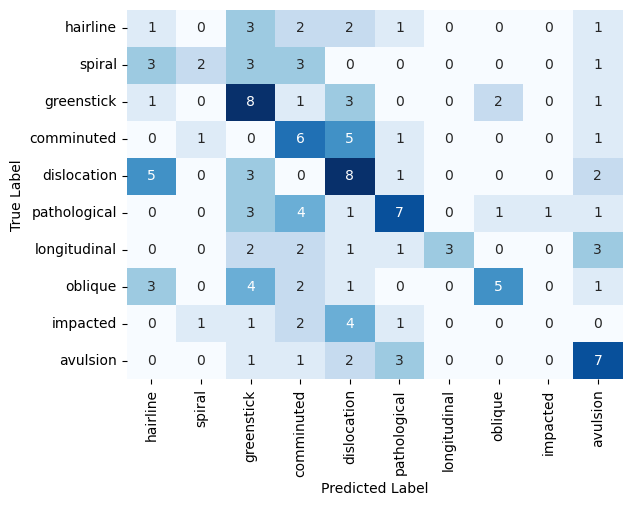

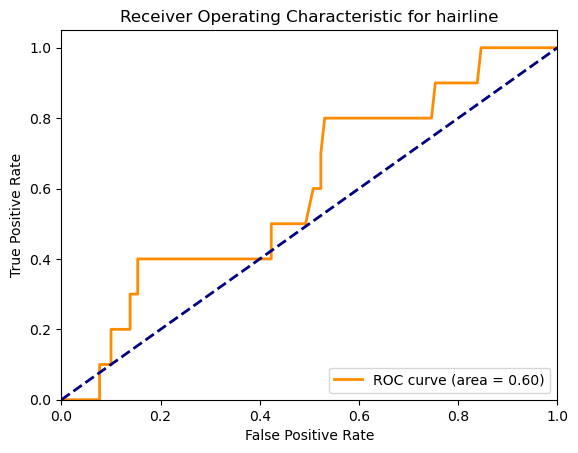

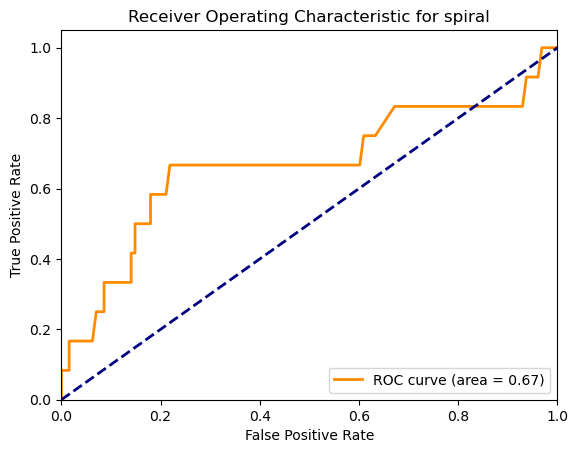

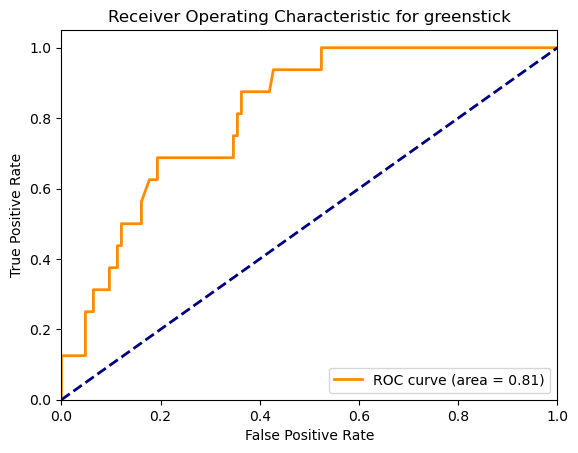

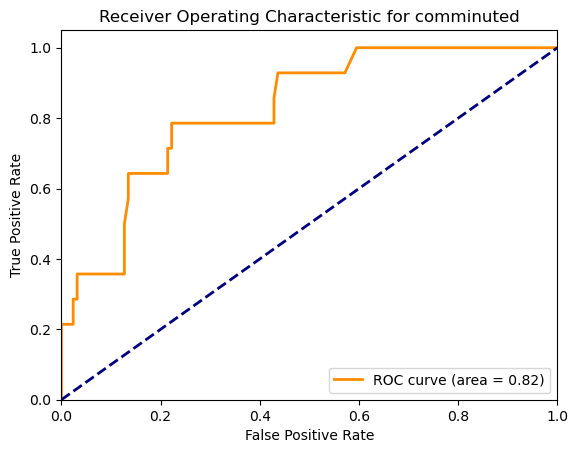

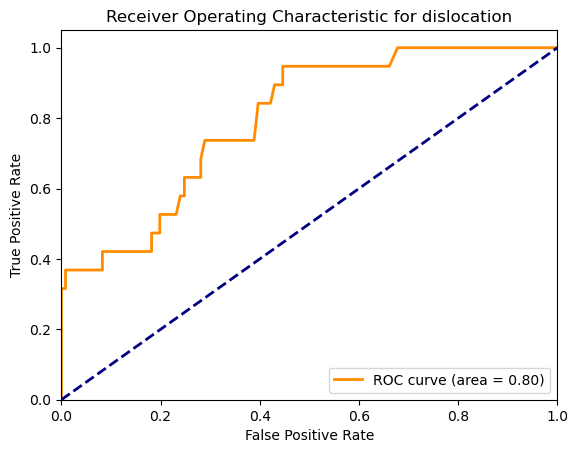

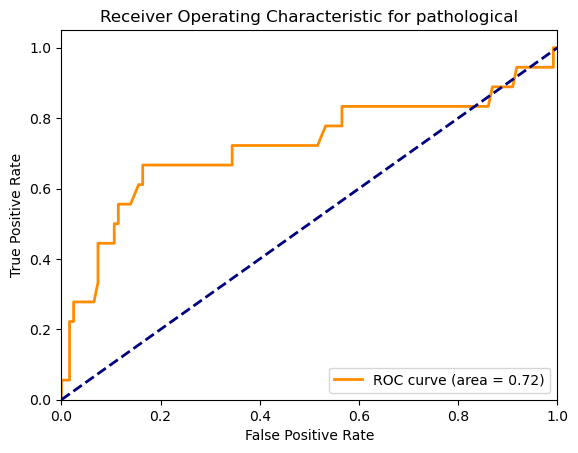

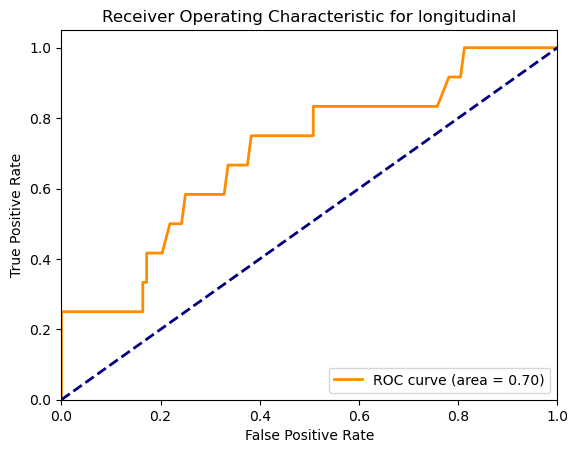

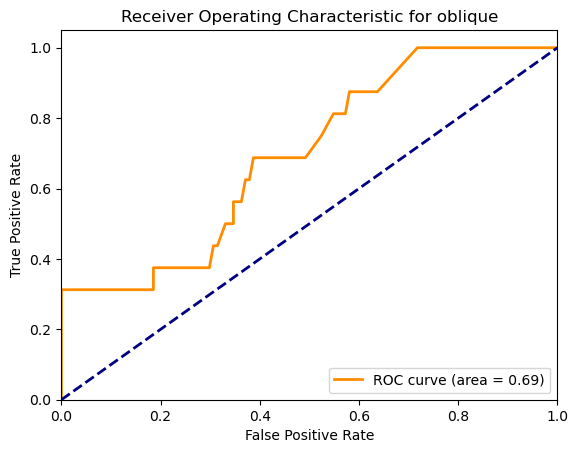

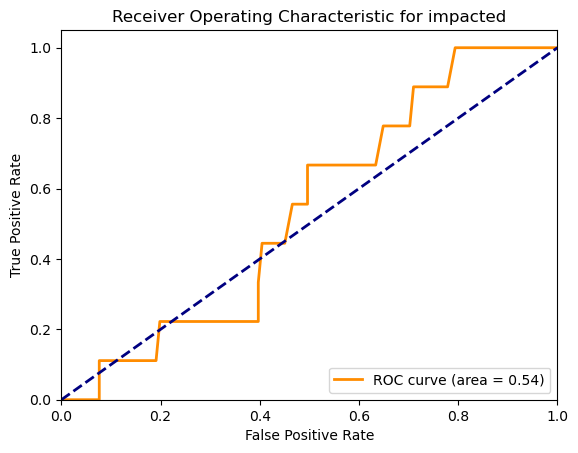

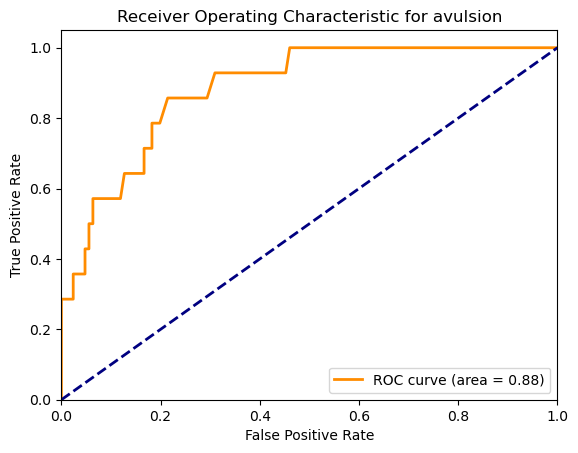

Accuracy: 0.3357142857142857
Classification Report:


,precision,recall,f1-score,support
hairline,0.076923,0.100000,0.086957,10.000000
spiral,0.500000,0.166667,0.250000,12.000000
greenstick,0.285714,0.500000,0.363636,16.000000
comminuted,0.260870,0.428571,0.324324,14.000000
dislocation,0.296296,0.421053,0.347826,19.000000
pathological,0.466667,0.388889,0.424242,18.000000
longitudinal,1.000000,0.250000,0.400000,12.000000
oblique,0.625000,0.312500,0.416667,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.388889,0.500000,0.437500,14.000000


In [14]:
y_pred = rf_1.predict(images_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_1.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report


## Model 2: HOG Feature Only

In [25]:
rf_2 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_2.fit(hog_train, y_train);


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


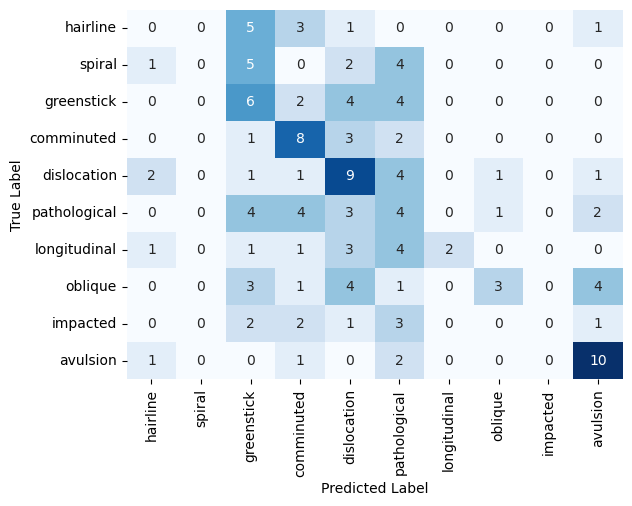

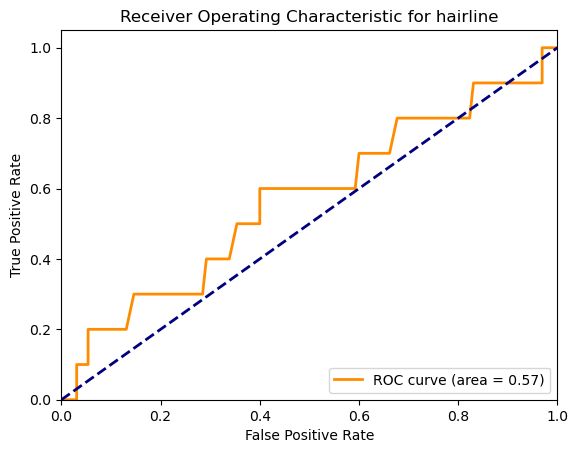

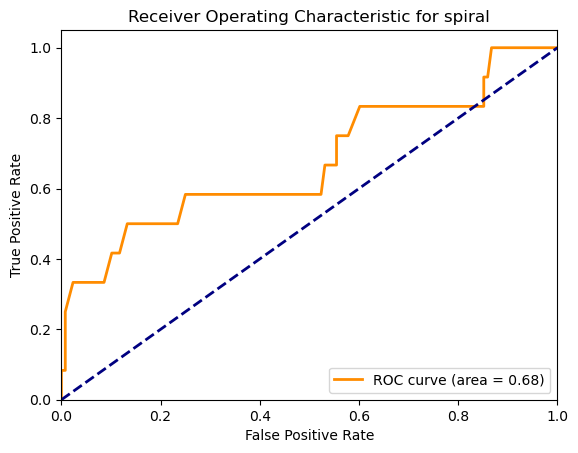

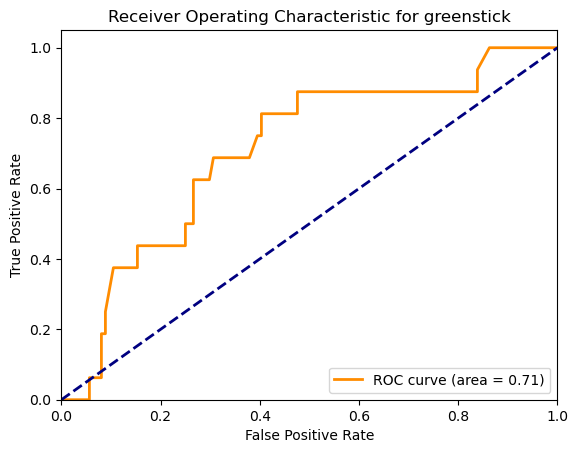

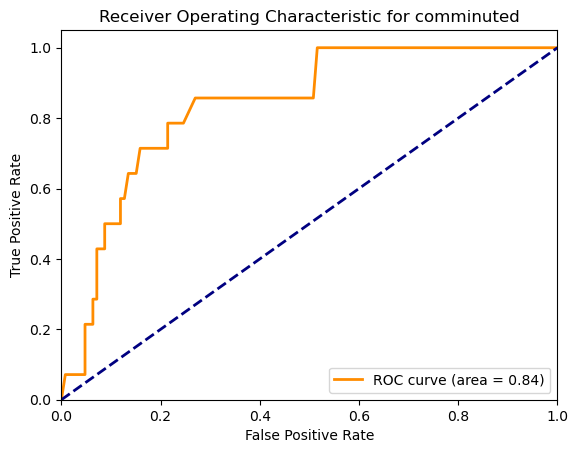

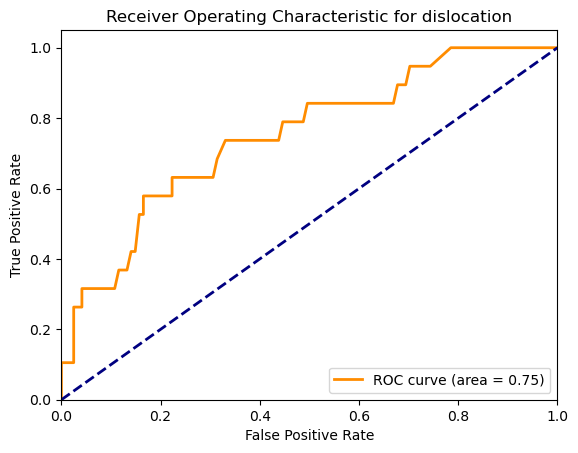

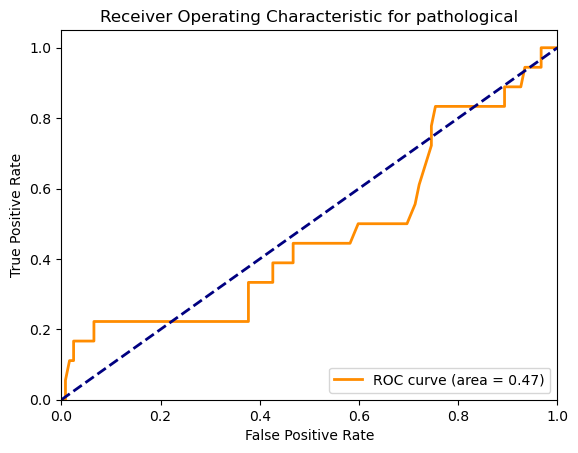

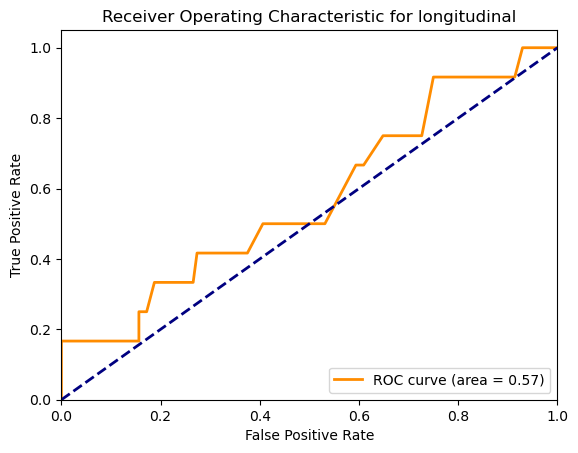

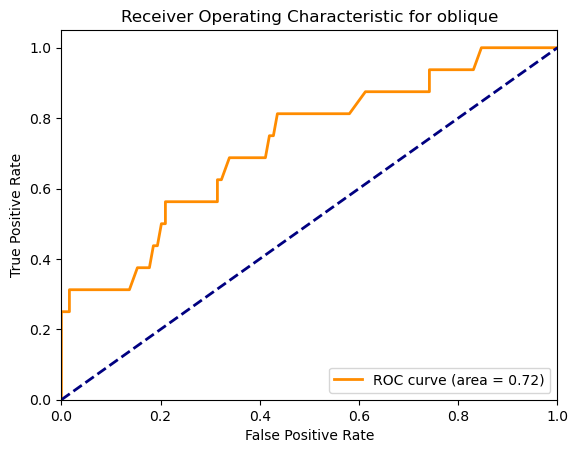

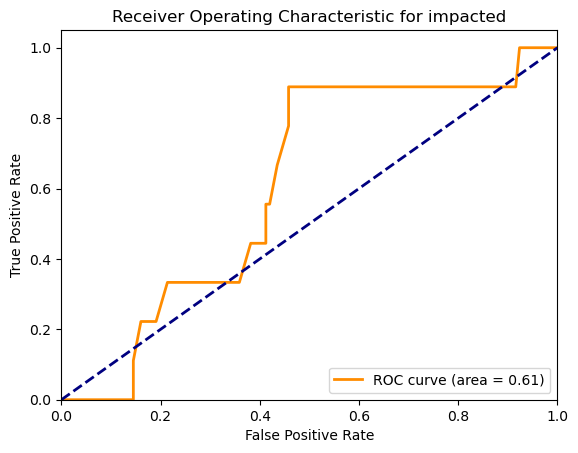

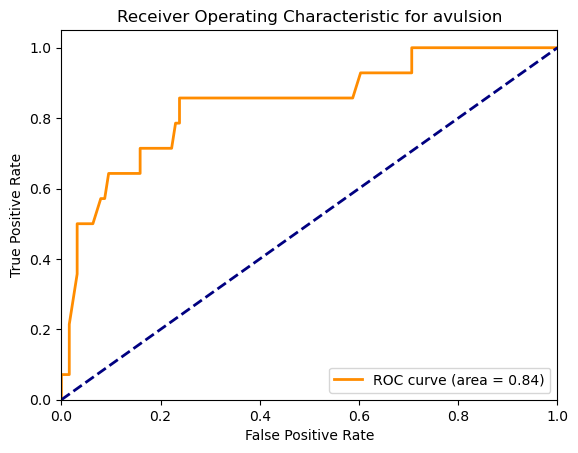

Accuracy: 0.3
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.0
spiral,0.000000,0.000000,0.000000,12.0
greenstick,0.214286,0.375000,0.272727,16.0
comminuted,0.347826,0.571429,0.432432,14.0
dislocation,0.300000,0.473684,0.367347,19.0
pathological,0.142857,0.222222,0.173913,18.0
longitudinal,1.000000,0.166667,0.285714,12.0
oblique,0.600000,0.187500,0.285714,16.0
impacted,0.000000,0.000000,0.000000,9.0
avulsion,0.526316,0.714286,0.606061,14.0


In [22]:
y_pred = rf_2.predict(hog_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_2.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [21]:
rf_3 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_3.fit(canny_edges_train, y_train);


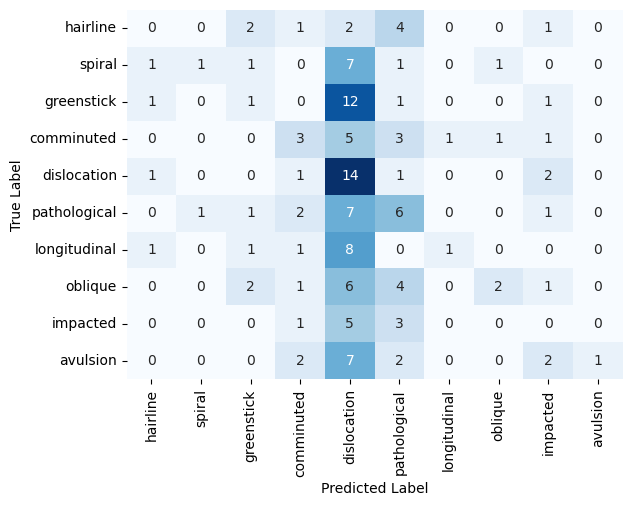

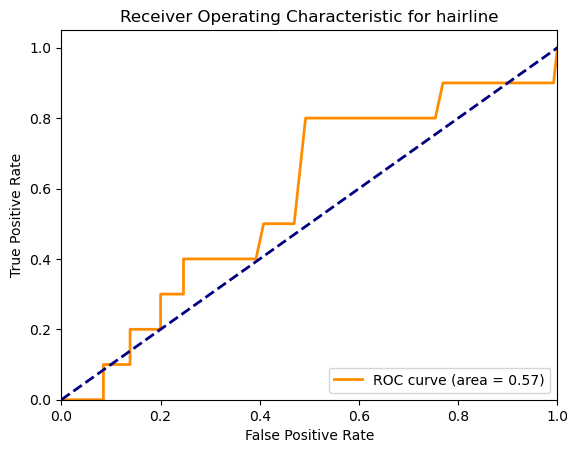

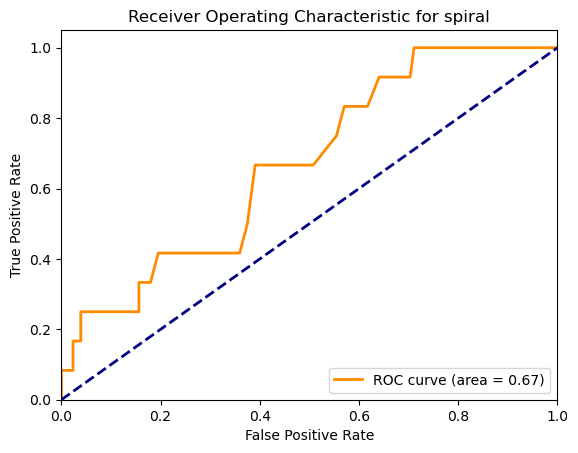

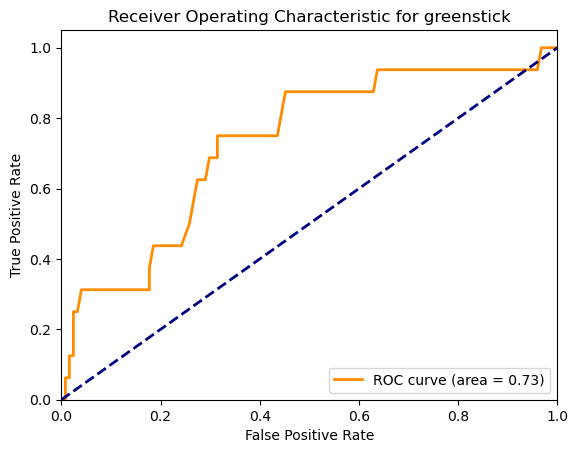

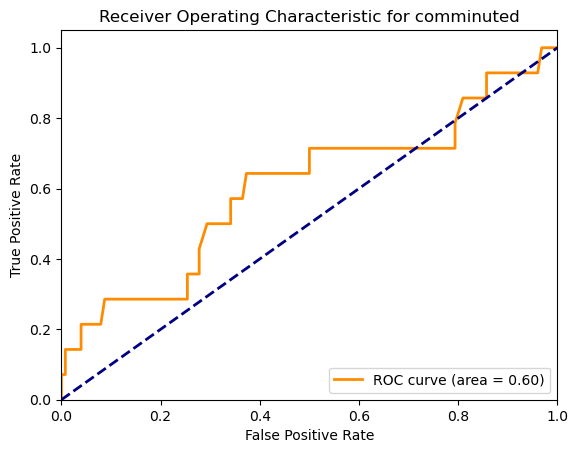

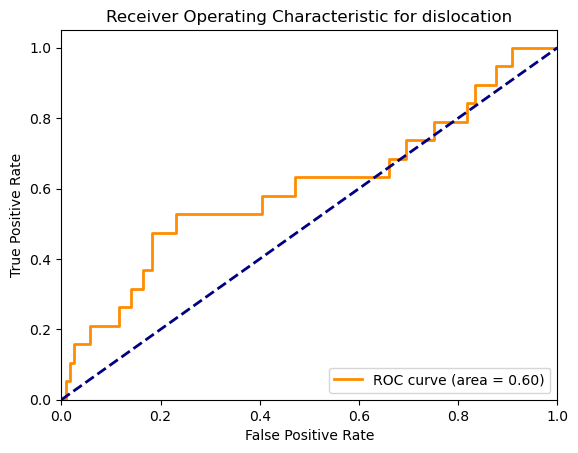

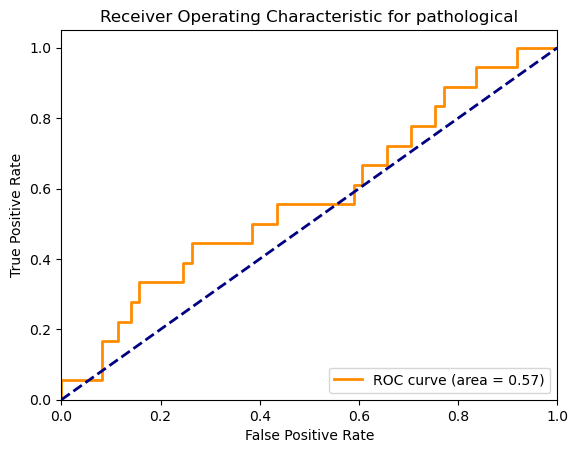

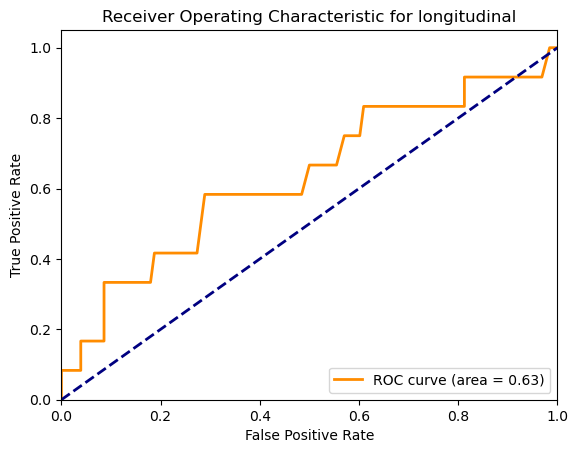

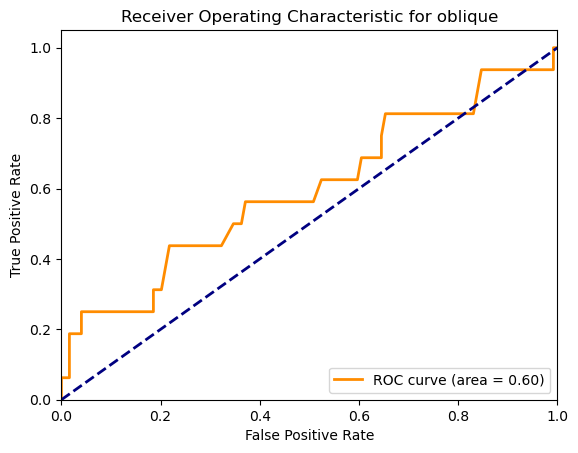

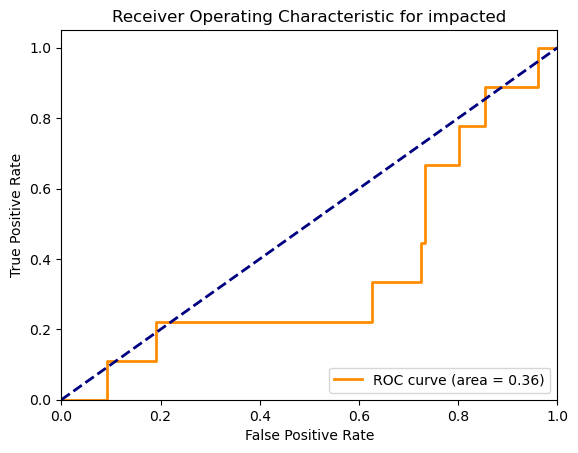

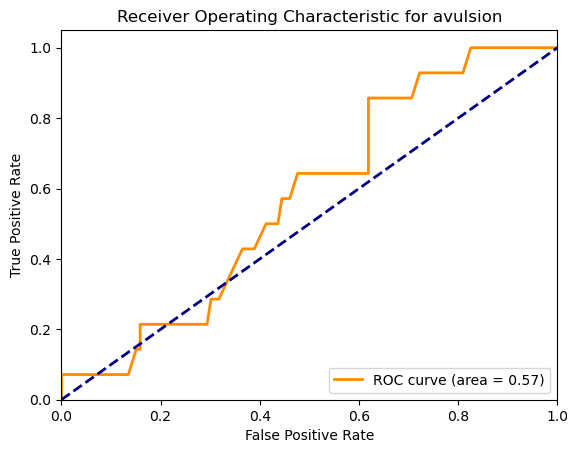

Accuracy: 0.20714285714285716
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.500000,0.083333,0.142857,12.000000
greenstick,0.125000,0.062500,0.083333,16.000000
comminuted,0.250000,0.214286,0.230769,14.000000
dislocation,0.191781,0.736842,0.304348,19.000000
pathological,0.240000,0.333333,0.279070,18.000000
longitudinal,0.500000,0.083333,0.142857,12.000000
oblique,0.500000,0.125000,0.200000,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,1.000000,0.071429,0.133333,14.000000


In [34]:
y_pred = rf_3.predict(canny_edges_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_3.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [23]:
rf_4 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_4.fit(contours_train, y_train);


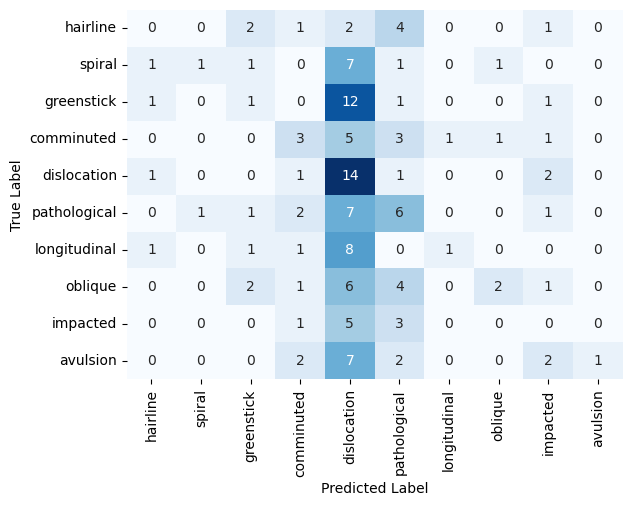

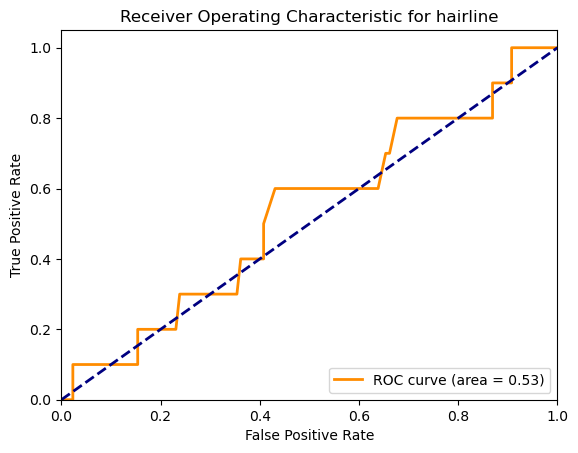

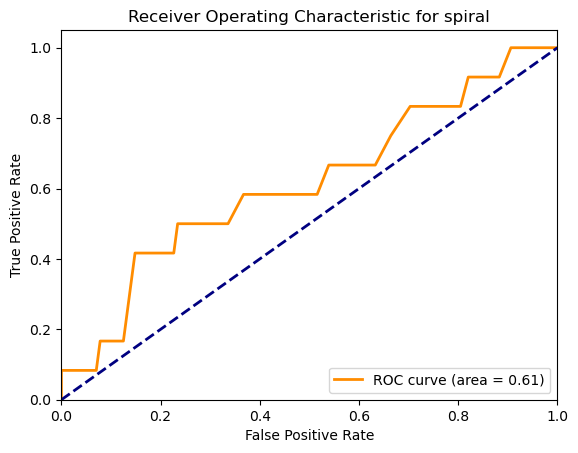

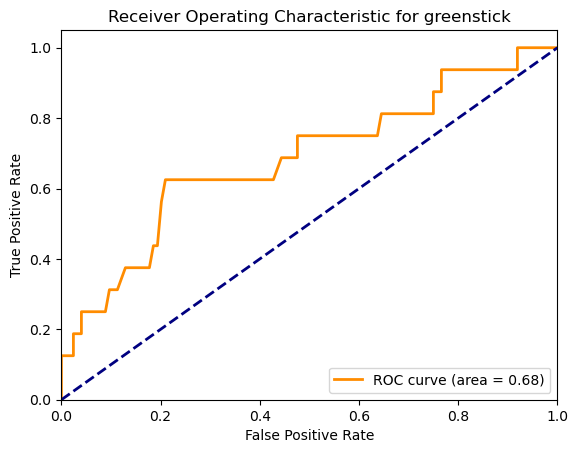

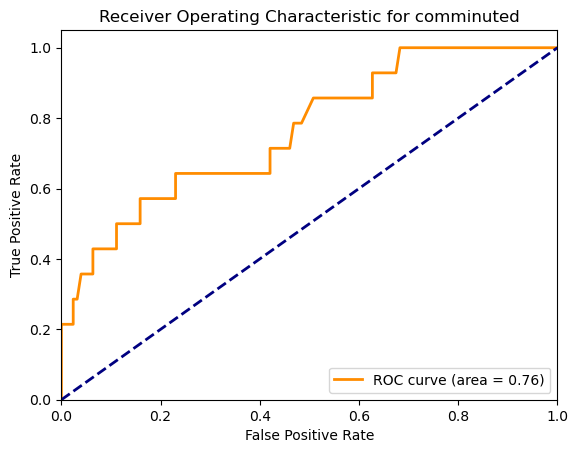

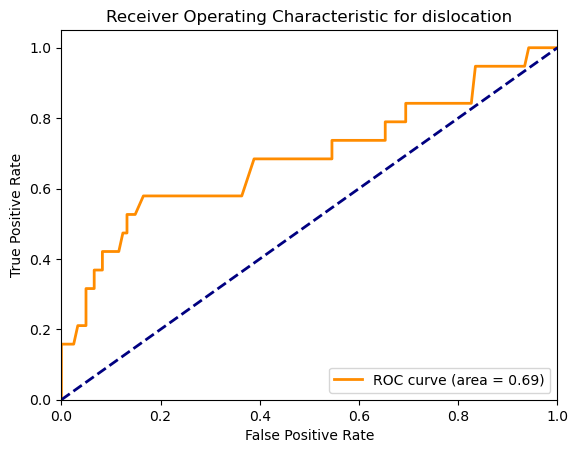

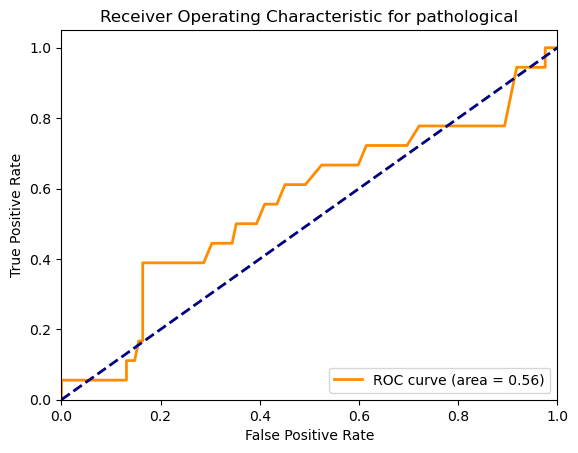

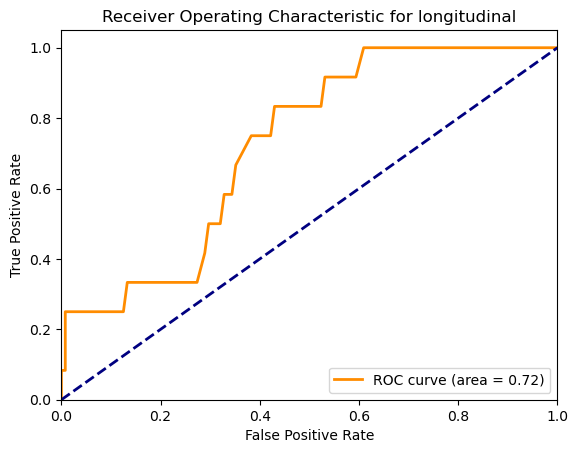

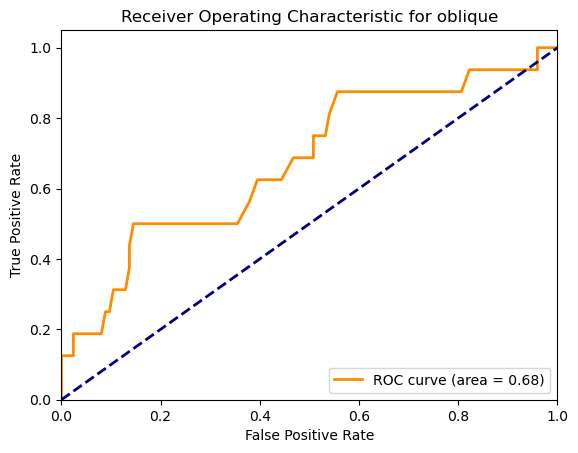

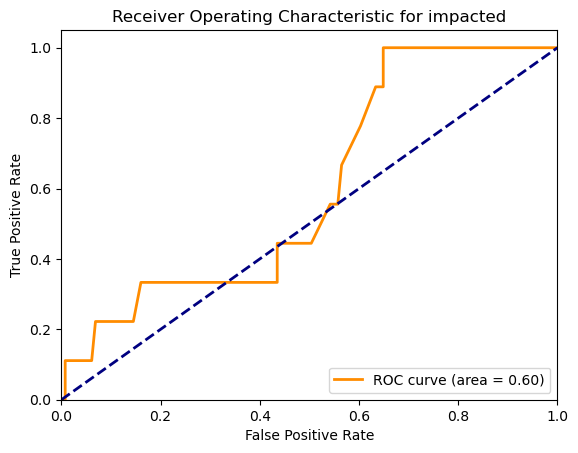

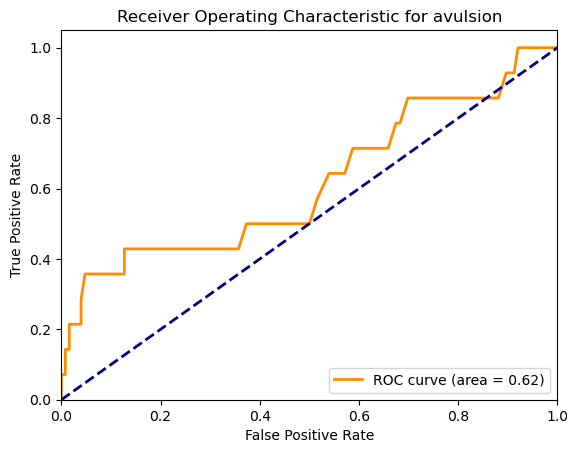

Accuracy: 0.22142857142857142
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.500000,0.083333,0.142857,12.000000
greenstick,0.125000,0.062500,0.083333,16.000000
comminuted,0.250000,0.214286,0.230769,14.000000
dislocation,0.191781,0.736842,0.304348,19.000000
pathological,0.240000,0.333333,0.279070,18.000000
longitudinal,0.500000,0.083333,0.142857,12.000000
oblique,0.500000,0.125000,0.200000,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,1.000000,0.071429,0.133333,14.000000


In [35]:
y_pred_images = rf_4.predict(contours_test)

accuracy = accuracy_score(y_test, y_pred_images)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_4.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: VGG 19

In [26]:
rf_5 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_5.fit(vgg19_train, y_train);


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


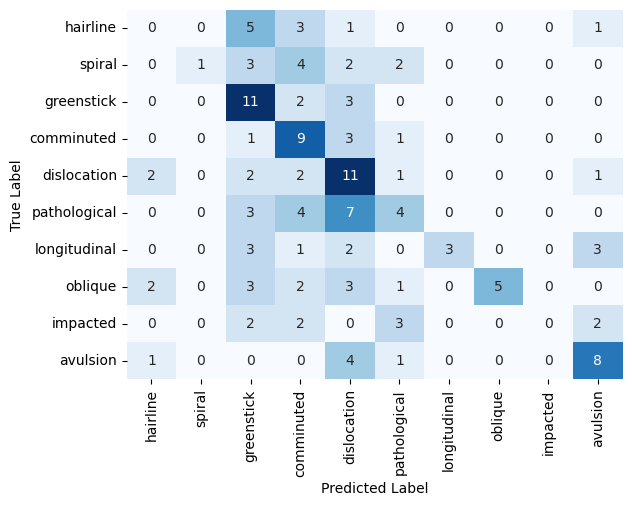

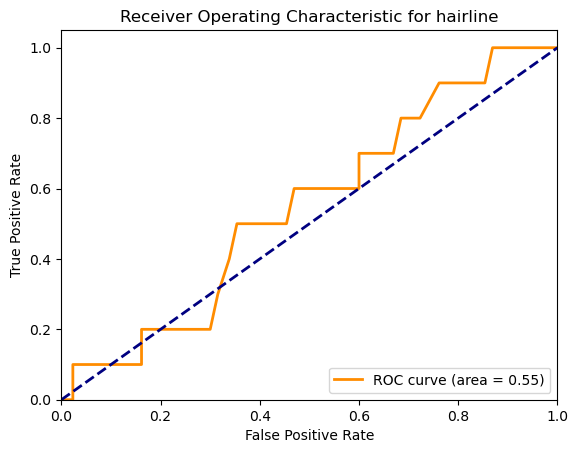

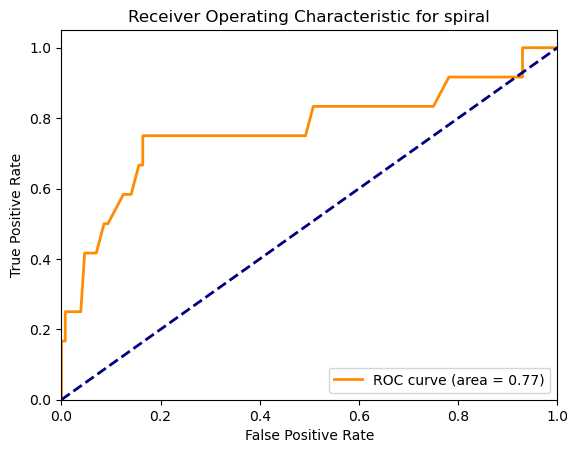

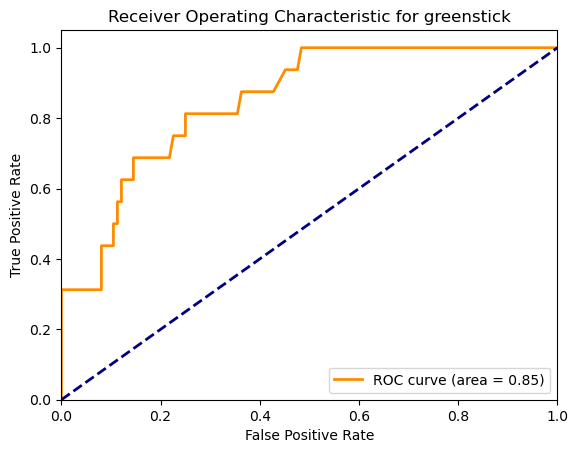

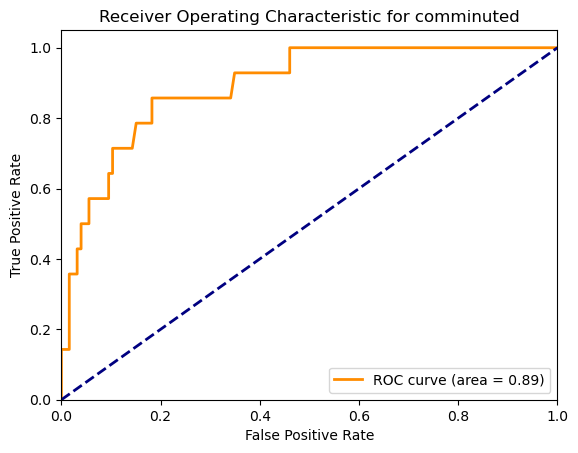

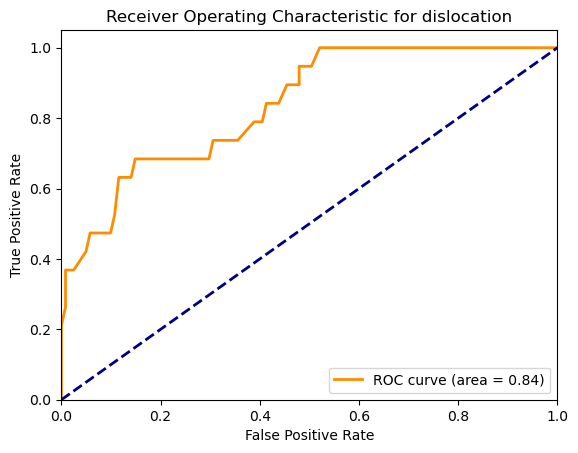

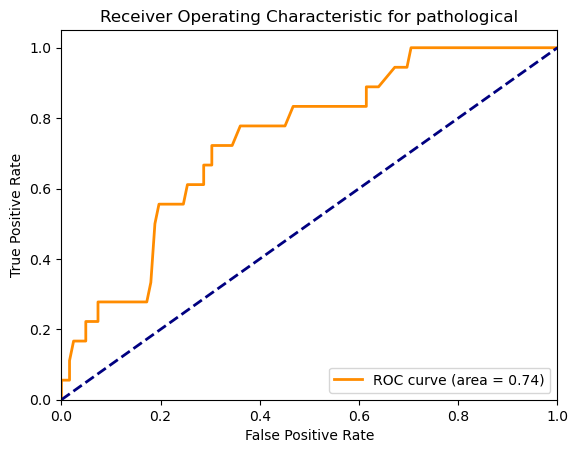

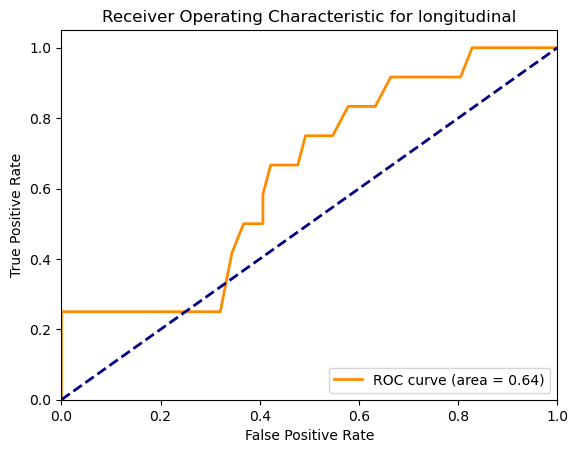

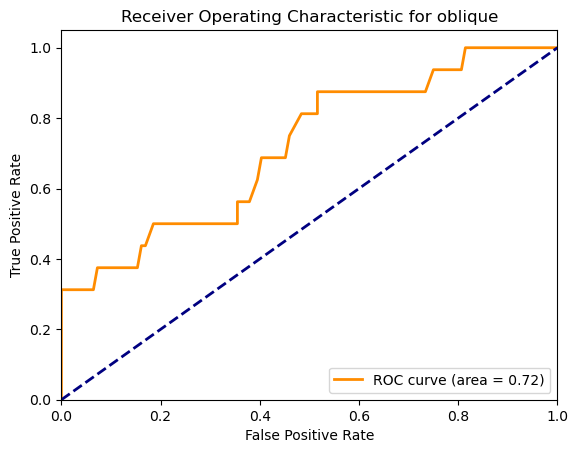

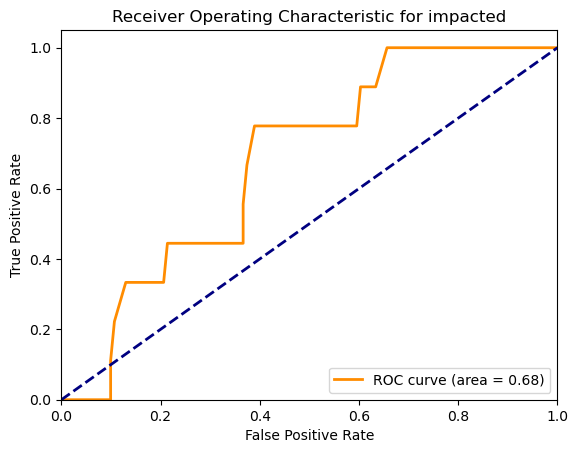

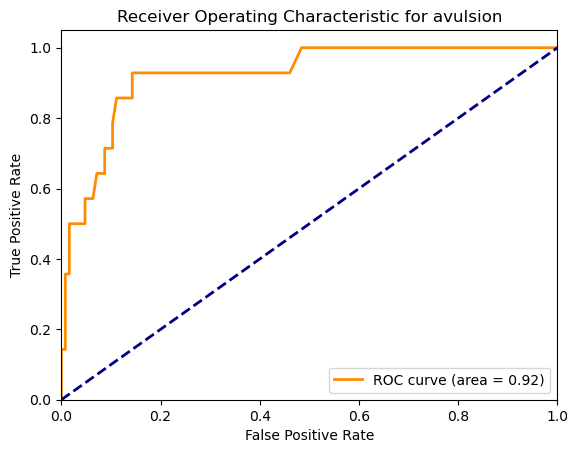

Accuracy: 0.37142857142857144
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,1.000000,0.083333,0.153846,12.000000
greenstick,0.333333,0.687500,0.448980,16.000000
comminuted,0.310345,0.642857,0.418605,14.000000
dislocation,0.305556,0.578947,0.400000,19.000000
pathological,0.307692,0.222222,0.258065,18.000000
longitudinal,1.000000,0.250000,0.400000,12.000000
oblique,1.000000,0.312500,0.476190,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.533333,0.571429,0.551724,14.000000


In [24]:
y_pred = rf_5.predict(vgg19_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_5.predict_proba(vgg19_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 6: Best Combination

In [19]:
X_train = np.hstack((images_train, vgg19_train))
X_test = np.hstack((images_test, vgg19_test))


In [20]:
rf_6 = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features='sqrt', criterion = 'gini', bootstrap = False)
rf_6.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, n_estimators=1000, random_state=42)

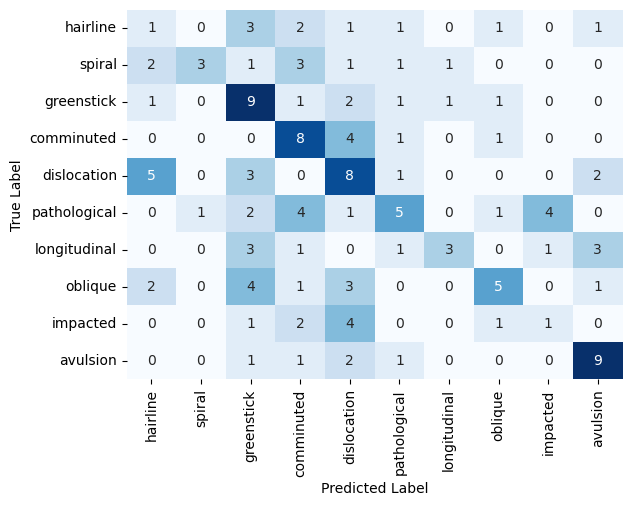

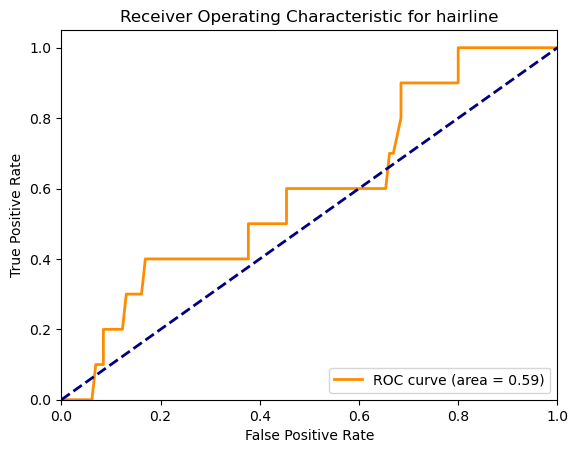

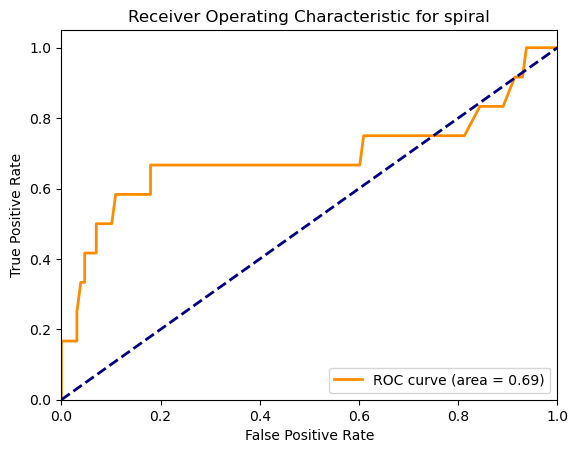

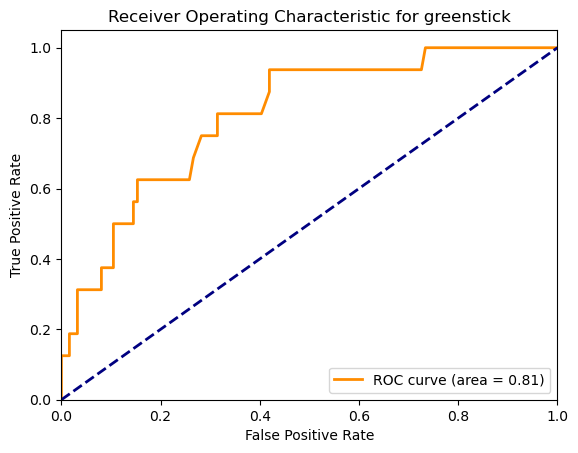

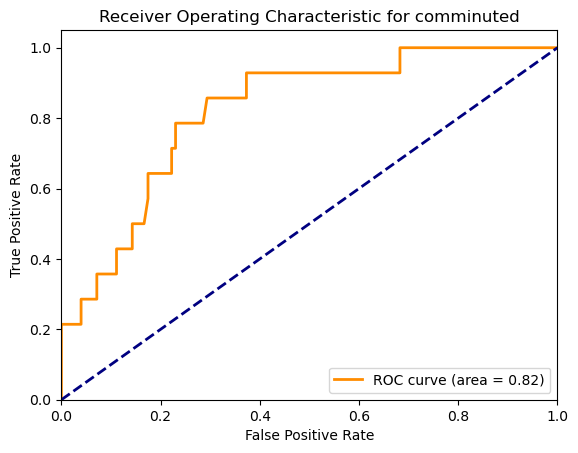

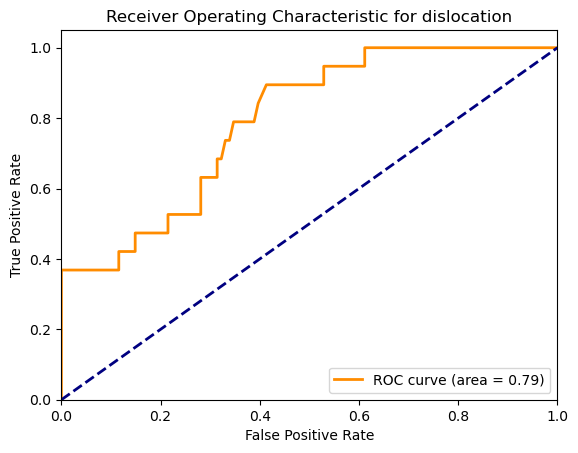

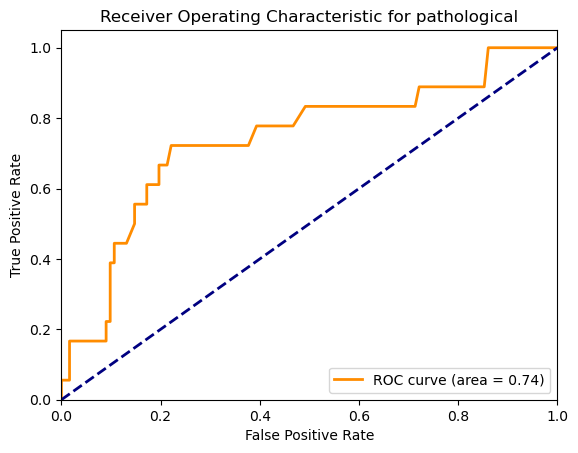

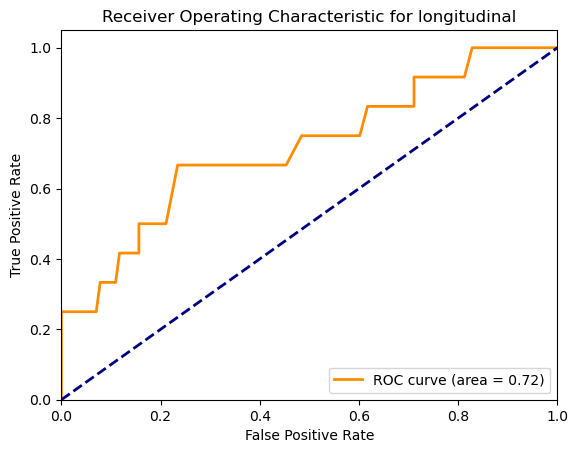

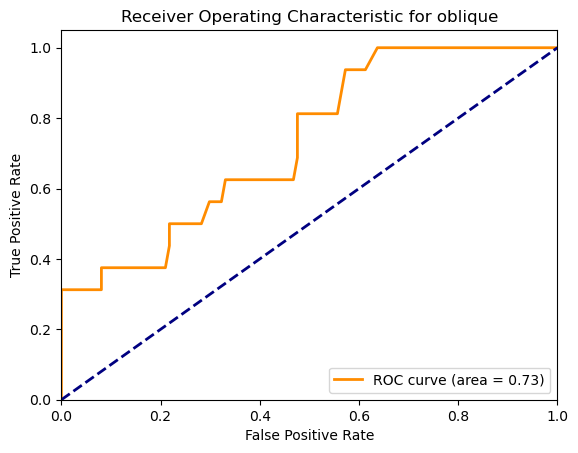

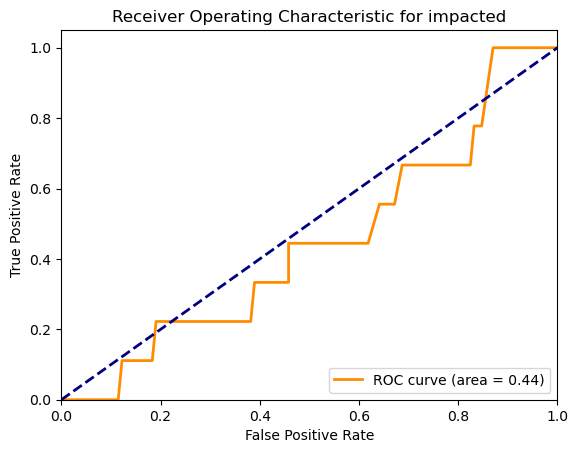

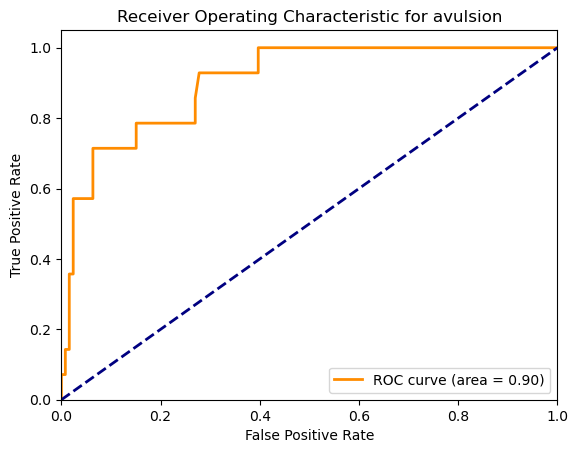

Accuracy: 0.37142857142857144
Classification Report:


,precision,recall,f1-score,support
hairline,0.090909,0.100000,0.095238,10.000000
spiral,0.750000,0.250000,0.375000,12.000000
greenstick,0.333333,0.562500,0.418605,16.000000
comminuted,0.347826,0.571429,0.432432,14.000000
dislocation,0.307692,0.421053,0.355556,19.000000
pathological,0.416667,0.277778,0.333333,18.000000
longitudinal,0.600000,0.250000,0.352941,12.000000
oblique,0.500000,0.312500,0.384615,16.000000
impacted,0.166667,0.111111,0.133333,9.000000
avulsion,0.562500,0.642857,0.600000,14.000000


In [21]:
y_pred_images = rf_6.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_images)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = rf_6.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

In [12]:
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.306 total time=  47.8s
[CV 2/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.345 total time=  49.8s
[CV 3/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.340 total time=  45.8s
[CV 1/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.324 total time=  21.3s
[CV 2/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.370 total time=  21.1s
[CV 3/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.325 total time=  21.6s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.324 total time=  52.8s
[CV 2/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.345 total time=  53.9s
[CV 3/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.328 total time=  53.0s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=log2;,

In [13]:
model = rand_search.best_estimator_
start_time = time.time()

y_pred = model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 1.86 seconds


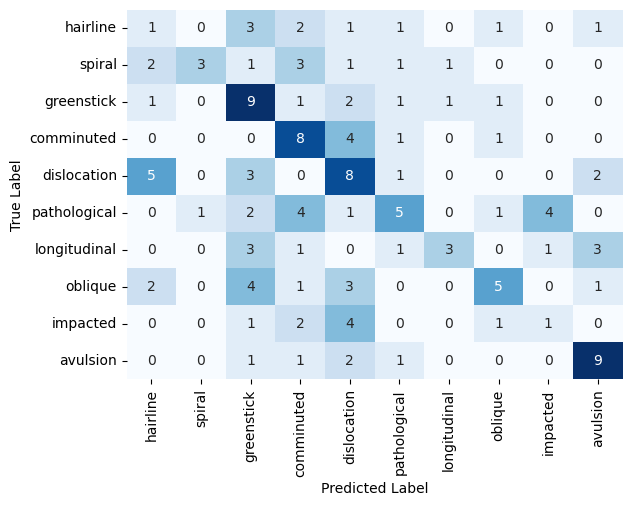

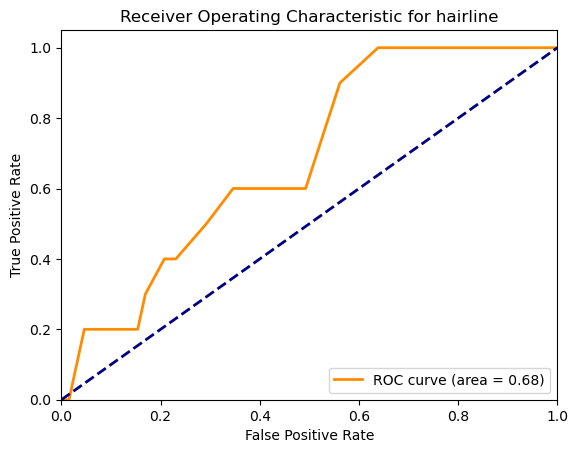

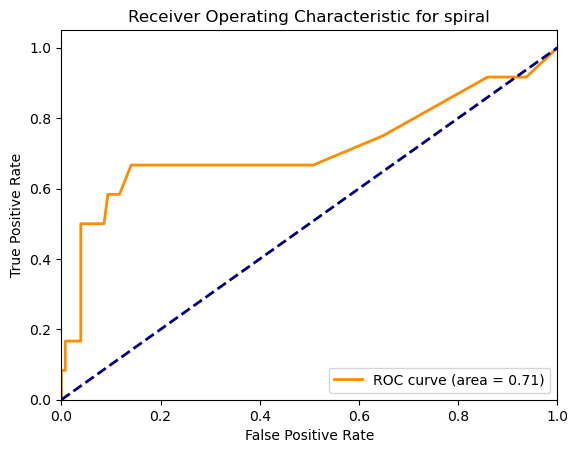

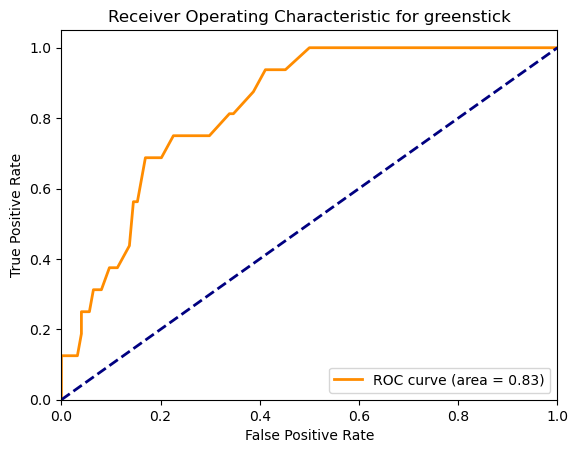

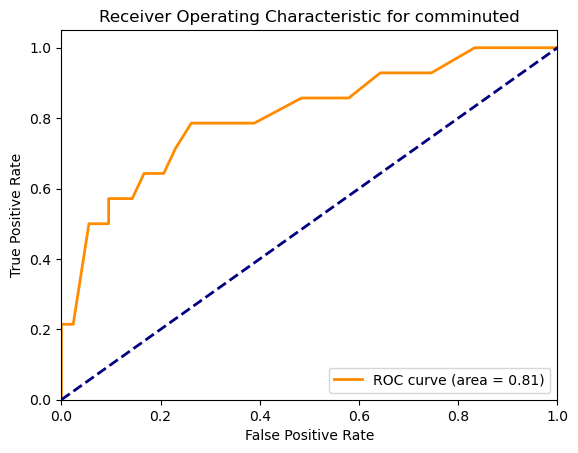

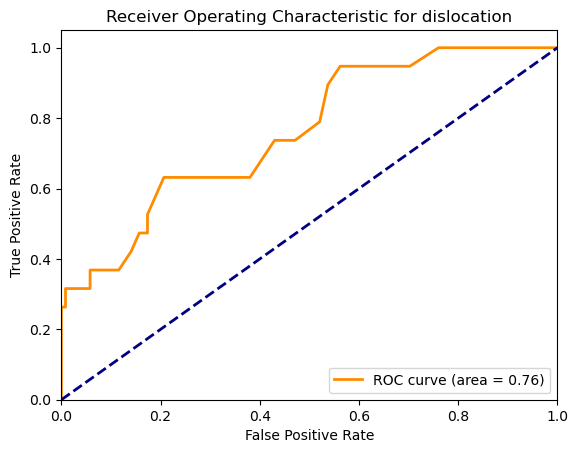

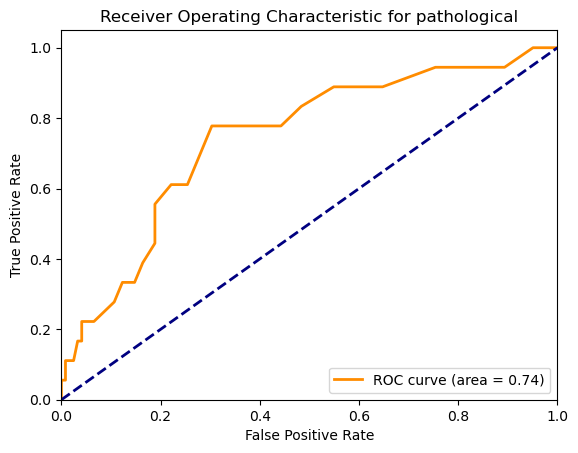

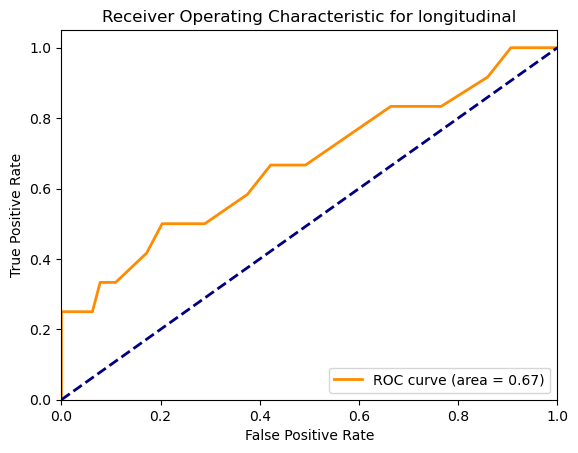

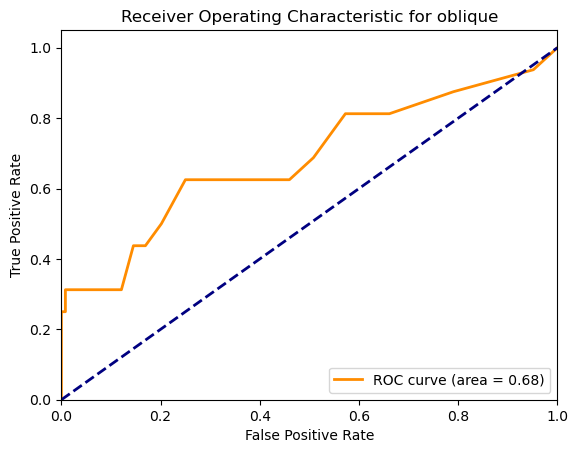

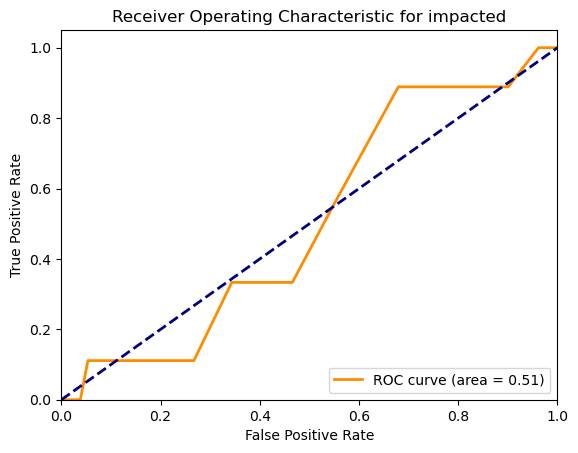

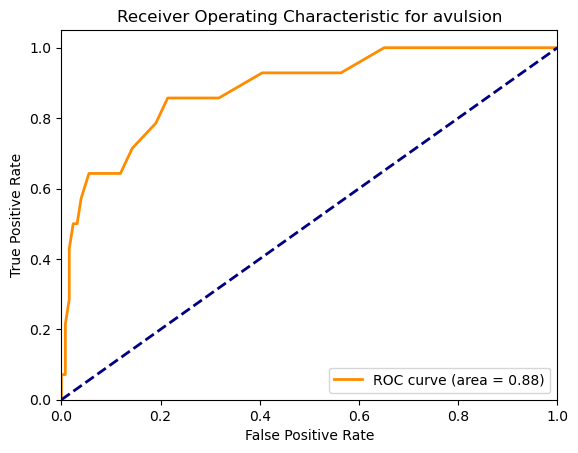

Accuracy: 0.37142857142857144
Classification Report:


,precision,recall,f1-score,support
hairline,0.090909,0.100000,0.095238,10.000000
spiral,0.750000,0.250000,0.375000,12.000000
greenstick,0.333333,0.562500,0.418605,16.000000
comminuted,0.347826,0.571429,0.432432,14.000000
dislocation,0.307692,0.421053,0.355556,19.000000
pathological,0.416667,0.277778,0.333333,18.000000
longitudinal,0.600000,0.250000,0.352941,12.000000
oblique,0.500000,0.312500,0.384615,16.000000
impacted,0.166667,0.111111,0.133333,9.000000
avulsion,0.562500,0.642857,0.600000,14.000000


In [15]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

In [16]:
X_train = np.hstack((images_train, hog_train, vgg19_train))
X_test = np.hstack((images_test, hog_test, vgg19_test))


In [17]:
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.291 total time= 1.5min
[CV 2/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.358 total time= 1.3min
[CV 3/3] END bootstrap=True, criterion=gini, max_features=sqrt;, score=0.307 total time= 1.3min
[CV 1/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.312 total time=  49.6s
[CV 2/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.364 total time=  56.3s
[CV 3/3] END bootstrap=True, criterion=gini, max_features=log2;, score=0.313 total time=  53.4s
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.288 total time= 1.4min
[CV 2/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.352 total time= 1.4min
[CV 3/3] END bootstrap=True, criterion=entropy, max_features=sqrt;, score=0.277 total time= 1.4min
[CV 1/3] END bootstrap=True, criterion=entropy, max_features=log2;,